# Sugges_

One of the strategies to improve user experience is to provide user with hints, or, otherwise, to autocomplete his queries. Let's consider suggest.

Today we will practice generating suggestions using [Trie](https://en.wikipedia.org/wiki/Trie) data structure (prefix tree), see the example below.

Plan of your homework:

1. Build Trie based on real search query data, provided by AOL company;
2. Generate suggestion based on a trie;
3. Measure suggestion speed;
4. [M] Add spellcheck to suggest.


![image](https://www.ritambhara.in/wp-content/uploads/2017/05/Screen-Shot-2017-05-01-at-4.01.38-PM.png)

## 0. Install Trie data structure support

You are free to use any library implementation of Trie, as well as the one we suggest (read the docs before asking any questions!): https://github.com/google/pygtrie

In [3]:
!pip3 install pygtrie

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Preparing metadata (setup.py) ... done
  Created wheel for pygtrie: filename=pygtrie-2.4.2-py3-none-any.whl size=19061 sha256=2fe91940f4c9ba9b99364afa57a4cb240cc85eec034e046cf648fa7dd184227a
  Stored in directory: /Users/bl7awy/Library/Caches/pip/wheels/2e/5d/81/d6e52fec193180ffffef19b185ecf1d0a85d418808c20c09c9
Successfully built pygtrie
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If y

### 0.1. Check it works and understand the example

In [1]:
import pygtrie
t = pygtrie.CharTrie()

# trie can be considered as a form of organizing a set of map
t["this is 1"] = "A"
t["this is 2"] = "B"
t["that is 3"] = "C"

print(t)

# "this" string is present in a set
n = t.has_node('this') == pygtrie.Trie.HAS_VALUE
# "this" prefix is present in a set
s = t.has_node('this') == pygtrie.Trie.HAS_SUBTRIE

print(f"Node = {n}\nSubtree = {s}")

# iterate a subtree
for key, val in t.iteritems("this"):
    print(key, '~', val)

CharTrie(this is 1: A, this is 2: B, that is 3: C)
Node = False
Subtree = True
this is 1 ~ A
this is 2 ~ B


## 1. Build a trie upon a dataset

### 1.1. [5] Read the dataset

Download the [dataset](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/aol) (we provide only the first part of the original data for simplicity (~3.5 mln queries)).

Explore the data, see readme file. Load the dataset. Pass the assert.

In [2]:
import pandas as pd

aol_data = None

#TODO: Read the dataset, e.g. as pandas dataframe
aol_data = pd.read_csv('../../datasets/aol/user-ct-test-collection-01.txt.gz', delimiter='\t', compression='gzip')

assert aol_data.shape[0] == 3558411, "Dataset size does not match"

In [3]:
aol_data.head(5)

,AnonID,Query,QueryTime,ItemRank,ClickURL
0,142,rentdirect.com,2006-03-01 07:17:12,NaN,NaN
1,142,www.prescriptionfortime.com,2006-03-12 12:31:06,NaN,NaN
2,142,staple.com,2006-03-17 21:19:29,NaN,NaN
3,142,staple.com,2006-03-17 21:19:45,NaN,NaN
4,142,www.newyorklawyersite.com,2006-03-18 08:02:58,NaN,NaN


### 1.2. [10] Build a Trie

We want a suggest function to be **non-sensitive to stop words** because we don't want to upset the users if they confuses/omits prepositions. Consider *"public events in Innopolis"* vs *"public events at Innopolis"* or *"public events Innopolis"* - they all mean the same.

Build a Trie based on the dataset, **storing query statistics such as query _frequency_, urls and ranks in the nodes**. Some queries may have no associated urls, others may have multiple ranked urls. Think of the way to store this information.

Pass the asserts.

In [4]:
stops = set('a on at of to is from for and with using the in &'.split())

In [5]:
import numpy as np
from tqdm import tqdm, tqdm_notebook

tqdm.pandas()

aol_trie = pygtrie.CharTrie()

#TODO: build a trie based on the dataset
class TrieItem:
    def __init__(self):
        self.urls = []
        self.frequency = 0
        self.queries = set()
    def add_query(self, query, url, rank):
        if url is not None:
            self.urls.append([url, rank])
        self.frequency += 1
        self.queries.add(query)

def generate_trie(dataset):
    trie = pygtrie.CharTrie()
    N = len(dataset)
    for idx, row in tqdm(dataset.iterrows(), total=N):
        row.replace(np.nan, None, inplace=True)
        query, url, rank = row['Query'], row['ClickURL'], row['ItemRank']
        if query is None:
            query = ''

        key = query.split()
        key = [word for word in key if word not in stops]
        key = " ".join(key)

        if not trie.has_node(key) == pygtrie.Trie.HAS_VALUE:
            trie[key] = TrieItem()

        trie[key].add_query(query, url, rank)
    return trie

aol_trie = generate_trie(aol_data)

100%|██████████████████████████████| 3558411/3558411 [03:37<00:00, 16393.57it/s]


In [43]:
# test trie
bag = []
for key, val in aol_trie.iteritems("sample q"):
    print(key, '~', val)
    
    #NB: here we assume you store urls in a property of list type. But you can do something different. 
    bag += [link for [link, _] in val.urls]
    
    assert "sample question" in key, "All examples have `sample question` substring"
    assert key[:len("sample question")] == "sample question", "All examples have `sample question` starting string"

for url in ["http://www.surveyconnect.com", "http://www.custominsight.com", 
            "http://jobsearchtech.about.com", "http://www.troy.k12.ny.us",
            "http://www.flinders.edu.au", "http://uscis.gov"]:
    assert url in bag, "This url should be in a try"

sample question surveys ~ <__main__.TrieItem object at 0x2c160f5b0>
sample questions immigration interview ~ <__main__.TrieItem object at 0x2c34105e0>
sample questions interview ~ <__main__.TrieItem object at 0x2c3410880>
sample questions family interview ~ <__main__.TrieItem object at 0x2c3410850>
sample questions sociology race ethnicity ~ <__main__.TrieItem object at 0x2c3456c70>
sample questions biology ~ <__main__.TrieItem object at 0x2c3514070>
sample questions us citizenship test ~ <__main__.TrieItem object at 0x2ef4e3610>
sample questionarie teaching evaluation ~ <__main__.TrieItem object at 0x2d3653cd0>
sample questionnaire teaching evaluation ~ <__main__.TrieItem object at 0x2d3653160>
sample questionnaire clinical research coordinators certification ~ <__main__.TrieItem object at 0x2ef99c760>


## 2. [15] Write a suggest function which is non-sensitive to stop words

Suggest options for user query based on Trie you just built.
Output results sorted by frequency, print query count for each suggestion. If there is an url available, print the url too. If multiple url-s are available, print the one with the highest rank (the less the better).

Pass the asserts.

Question for analysis: What is the empirical threshold for minimal prefix for suggest?

In [173]:
def complete_user_query(query: str, trie, top_k=5) -> list[str]:
    #TODO: suggest top_k options for a user query
    # sort results by frequency (!!), 
    # suggest the QUERIES for first k ranked urls if available
    
    if not aol_trie.has_node(query) == pygtrie.Trie.HAS_SUBTRIE:
        return []
    
#     print("All suggestions: Query, Link, Rank, Frequency")
#     for key, value in aol_trie.items(query):
#         if(not value.urls == []):
#             url, rank = min(value.urls, key=lambda tup: tup[1])
#         else:
#             url, rank = None, None
#         print(key, "|", url, "|", rank, "|", value.frequency)

    suggestions = [(q, value.frequency) for key, value in aol_trie.items(query)
                                        for q in list(value.queries)]
    suggestions.sort(key=lambda item: item[1], reverse=True)
        
    return [key for key, value in suggestions][:min(top_k, len(suggestions))]

In [174]:
inp = "trie"
print("Query:", inp)
print("Results:")
res = complete_user_query(inp, aol_trie)
print(res)

#NB we assume you return suggested query string only
assert res[0] == "tried and true tattoo"
assert res[1] == "triest" or res[1] == "triethanalomine"

assert "boys and girls club of conyers georgia" \
            in complete_user_query("boys girls club conyers", aol_trie, 10), "Should be here"

Query: trie
Results:
['tried and true tattoo', 'triest', 'triethanalomine', 'tried and failed', "tried and truechildren's consignment sale"]


## 3. Measure suggest speed ##

### 3.1. [10] Full Trie test

Check how fast your search is working. Consider changing your code if it takes too long on average.

Sucess criterion:
- there is an average and variance for **multiple runs** of the given bucket.
- there is an average and variance for **multiple runs** of naive search in unindexed dataset.

In [8]:
import time

inp_queries = ["inf", "the best ", "information retrieval", "sherlock hol", "carnegie mell", 
               "babies r", "new york", "googol", "inter", "USA sta", "Barbara "]

#TODO: measure avg execution time (in milliseconds) per query and print it out
def query_trie_avg_time(query, num_tries=20):
    times = []
    for _ in range(num_tries):
        start = time.time()
        res = complete_user_query(query, aol_trie)
        end = time.time()
        t = (end - start) * 1000
        times.append(t)
    return sum(times)/num_tries

def naive_search(prefix, dataset):
    res = []
    
    for idx, row in dataset.iterrows():
        q = row['Query']
        if(not q is np.nan and q.startswith(prefix)):
            res.append(q)
    return res

def query_naive_avg_time(query, num_tries=5):
    times = []
    for _ in range(num_tries):
        start = time.time()
        res = naive_search(query, aol_data)
        end = time.time()
        t = (end - start) * 1000
        times.append(t)
    return sum(times)/num_tries
    

trie_times = []
naive_times = []

for query in inp_queries:
    trie_time = query_trie_avg_time(query)
    naive_time = query_naive_avg_time(query)
    print(f'query string: "{query}", avg time with trie: {trie_time}, avg time without trie: {naive_time}')
    
    trie_times.append(trie_time)
    naive_times.append(naive_time)

print(f'Average trie time over all queries: {sum(trie_times)/len(trie_times)}, variance: {np.var(trie_times)}')
print(f'Average naive time over all queries: {sum(naive_times)/len(naive_times)}, variance: {np.var(naive_times)}')

query string: "inf", avg time with trie: 0.004780292510986328, avg time without trie: 43085.06336212158
query string: "the best ", avg time with trie: 0.0013113021850585938, avg time without trie: 43065.54193496704
query string: "information retrieval", avg time with trie: 0.0029325485229492188, avg time without trie: 43154.944372177124
query string: "sherlock hol", avg time with trie: 0.038492679595947266, avg time without trie: 43113.68336677551
query string: "carnegie mell", avg time with trie: 0.01933574676513672, avg time without trie: 42959.504985809326
query string: "babies r", avg time with trie: 0.008213520050048828, avg time without trie: 42913.1058216095
query string: "new york", avg time with trie: 0.004136562347412109, avg time without trie: 42949.008321762085
query string: "googol", avg time with trie: 0.0036478042602539062, avg time without trie: 42936.806201934814
query string: "inter", avg time with trie: 0.004589557647705078, avg time without trie: 42835.758781433105


### 3.2. [M][10] Assess how dataset size affect search time

Study the speed of the trie data structure in $\frac{1}{10}, \frac{1}{4}, \frac{1}{2}$, and full dataset. 
- Sample the data at random.
- Plot the graph which shows how search time changes with dataset size.
- Compare aganist bruteforce.

In [9]:
import numpy as np

N = len(aol_data)
sizes = np.linspace(0.1, 1, num=10)
trie_y = []
naive_y = []

for sample_size in sizes:
    dataset = aol_data.sample(n=int(sample_size * N))
    trie = generate_trie(dataset)

    trie_y.append(query_trie_avg_time(inp_queries[0]))
    naive_y.append(query_naive_avg_time(inp_queries[0]))

100%|██████████████████████████████| 3558411/3558411 [04:16<00:00, 13897.64it/s]


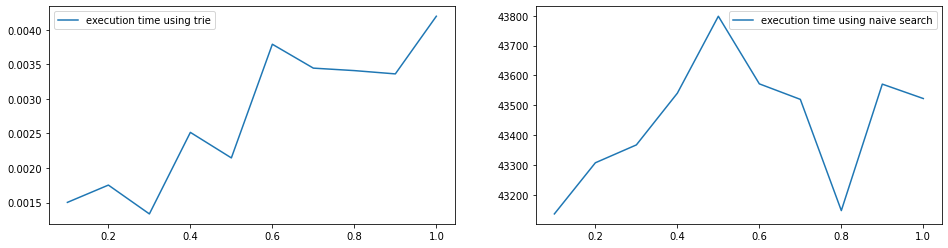

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(sizes, trie_y, label="execution time using trie")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(sizes, naive_y, label="execution time using naive search")
plt.legend()
plt.show()

## 4. [10] Add spellchecking to your suggest

Try to make your search results as close as possible. Compare top-5 results of each query with top-5 results for corrected.

You can use use [pyspellchecker](https://pypi.org/project/pyspellchecker/) `candidates()` call, or use any other spellchecker implementation.

In [21]:
!pip3 install pyspellchecker

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 3.2 MB/s eta 0:00:0000:0100:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [170]:
from spellchecker import SpellChecker
from itertools import product

def complete_user_query_with_spellchecker(query, trie, top_k=5) -> list[str]:
    #TODO: suggest top_k options for a user query
    # sort results by frequency (!!), 
    # suggest the QUERIES for first k ranked urls if available

    spell = SpellChecker()
    
    word_lst = query.split()
    
    unknown_words = list(spell.unknown(word_lst))
    unknown_words = [x for x in unknown_words if len(x) > 1]
    candidates = {x: list(spell.candidates(x)) for x in unknown_words}
    candidates = list(product(*candidates.values()))
    
    possible_queries = []
    for cand in candidates:
        new_word_lst = [x for x in word_lst]
        for wrong, fixed in zip(unknown_words, cand):
            for i in range(len(new_word_lst)):
                if(new_word_lst[i] == wrong):
                    new_word_lst[i] = fixed
        new_query = " ".join(new_word_lst)
        possible_queries.append(new_query)
    
    q_res = list(map(lambda x: complete_user_query(x, trie), possible_queries))
    res = sorted(q_res, key=lambda x: -len(x))
    
    if len(res):
        return res[0]

    return []
        

In [172]:
inp_queries = ["inormation retrieval", "shelrock hol", "carnagie mell", "babies r", "Barrbara "]
inp_queries_corrected = ["information retrieval", "sherlock hol", "carnegie mell", "babies r", "Barbara "]

for q, qc in zip(inp_queries, inp_queries_corrected):
    assert  complete_user_query(qc, aol_trie, 5) == \
            complete_user_query_with_spellchecker(q, aol_trie, 5), "Assert {} and {} give different results".format(q, qc)

## 5. [M][20] What if the query is in the middle?

Modify your code to suggest string even if the query is found **in the middle** of the text. Think about techniques you can borrow from our previous classes, e.g. about wildcard search.

E.g. `Semantic Parsing` in 

```
3DCNN-DQN-RNN: A Deep Reinforcement Learning Framework for Semantic Parsing of Large-scale 3D Point Clouds
                                                           ~~~~~~~~~~~~~~~~
```

**NB**: Please extend you trie-based approach. Even if using `in` and regexp can give you same result, this is not a scalable approach, which we will not accept.

Pass the asserts.

In [ ]:
newtrie = None

## YOUR CODE HERE

def complete_user_query_with_spellchecker_and_middle(query, trie, top_k=5) -> list[str]:
    #TODO: suggest top_k options for a user query
    # sort results by frequency (!!), 
    # suggest the QUERIES for first k ranked urls if available
    pass

In [ ]:
assert "ricky martin beach" in complete_user_query_with_spellchecker_and_middle(
            "martin beach", newtrie, 20)
assert "free adult movie" in  complete_user_query_with_spellchecker_and_middle(
            "adult movie", newtrie, 20)

## 6. [M][20] Enrich your suggest with search results

Your users will be happy if at typing the query they will see not only suggested queries, but also snippets of the answers to these queries!

Imagine you type "continental air", and the search engine suggests you "continental airlines" together with the URL and snippet kind of `"Continental Airlines was a major American airline founded in 1934 and eventually headquartered in Houston, Texas..."`, which you borrow from the search engine snippet. How can you add existing search enginge to your code? [One](https://yandex.com/dev/xml/doc/dg/task/quickstart.html), [two](https://docs.microsoft.com/en-us/bing/search-apis/bing-web-search/search-the-web), [three](https://searx.roughs.ru/), ...

Improve your suggest. It should return a tuple of 3 instead on a string: `(query, text, url)`. Write your own tests which will for the query `continental air` return among the results:
1. `query` = `continental airlines`.
2. 
`Continental Airlines was a major American airline founded in 1934` in `text`.
3. `url` = `https://en.wikipedia.org/wiki/Continental_Airlines`.

In [ ]:
def complete_user_query_with_spellchecker_and_middle_with_snippets(query, trie, top_k=5) -> list[tuple]:
    #TODO
    pass

In [ ]:
# YOUR TESTS HERE